# take2

**GOAL**: Keep It Stupid Simple = KISS.

**References**:
 1. [ilqgames/python](https://github.com/HJReachability/ilqgames/blob/master/python)

In [1]:
%load_ext autoreload
%autoreload 1
%aimport decentralized.control2

In [4]:
import functools

import numpy as np
import matplotlib.pyplot as plt
import torch

from decentralized import control2
import pocketknives

In [32]:
%matplotlib widget
plt.rcParams['axes.grid'] = True

<Figure size 640x480 with 0 Axes>

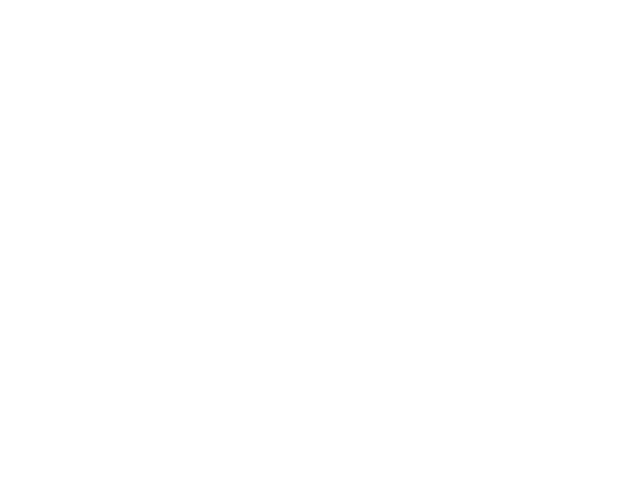

In [62]:
plt.figure()

## dynamics

In [91]:
def unicycle_continuous(x, u):
    """
    Compute the time derivative of state for a particular state/control.
    NOTE: `x` and `u` should be 2D (i.e. column vectors).
    REF: [1]
    """
    assert isinstance(x, torch.Tensor) and isinstance(u, torch.Tensor)

    x_dot = torch.zeros(x.numel())
    x_dot[0] = x[3] * torch.cos(x[2])
    x_dot[1] = x[3] * torch.sin(x[2])
    x_dot[2] = u[0]
    x_dot[3] = u[1]
    return x_dot

## costs

In [115]:
def QR_goal_cost(x, u, _x_goal, _Q, _R, _Qf=None, terminal=False):
    """Cost of reaching the goal"""
    
    assert isinstance(x, torch.Tensor) and isinstance(u, torch.Tensor)
    x = x.reshape(-1,1)
    u = u.reshape(-1,1)
    
    if _Qf is None:
        _Qf = torch.eye(Q.shape[0])
    
    if terminal:
        return (x - _x_goal).T @ _Qf @ (x - _x_goal)
    return (x - _x_goal).T @ _Q @ (x - _x_goal) + u.T @ _R @ u

## single-agent problem

In [119]:
dt = 0.1
N = 50
tol = 1e-6

x = torch.tensor([-10, 10, 0, 0], dtype=torch.float, requires_grad=True)
x_goal = torch.zeros((4, 1), dtype=torch.float)

Q = torch.diag(torch.tensor([1., 1, 0, 0]))
Qf = 1000 * torch.eye(Q.shape[0])
R = torch.eye(2)
goal_cost = functools.partial(QR_goal_cost, _x_goal=x_goal, _Q=Q, _R=R, _Qf=Qf)

ilqr = control2.iLQR(unicycle_continuous, goal_cost, x.numel(), 2, dt, N)
X, U, J = ilqr.solve(x, tol=tol)
plot_solve(X, U, J)

0/50	J: 209878
1/50	J: 140560	μ: 0.5	Δ: 0.5
2/50	J: 135350	μ: 0.125	Δ: 0.25
3/50	J: 57659.7	μ: 0.015625	Δ: 0.125
4/50	J: 5352.69	μ: 0.000976562	Δ: 0.0625
5/50	J: 3796.07	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 3190.39	μ: 0	Δ: 0.015625
7/50	J: 3113.08	μ: 0	Δ: 0.0078125
8/50	J: 3089.72	μ: 0	Δ: 0.00390625
9/50	J: 3078.74	μ: 0	Δ: 0.00195312
10/50	J: 3074.1	μ: 0	Δ: 0.000976562
11/50	J: 3072.02	μ: 0	Δ: 0.000488281
12/50	J: 3071.14	μ: 0	Δ: 0.000244141
13/50	J: 3070.76	μ: 0	Δ: 0.00012207
14/50	J: 3070.6	μ: 0	Δ: 6.10352e-05
15/50	J: 3070.53	μ: 0	Δ: 3.05176e-05
16/50	J: 3070.5	μ: 0	Δ: 1.52588e-05
17/50	J: 3070.48	μ: 0	Δ: 7.62939e-06
18/50	J: 3070.48	μ: 0	Δ: 3.8147e-06


## multi-agent problem

In [123]:
def _integrate_discrete(f, x, u, _dt):
    """Zero-order hold to discretize a state given continuous dynamics f"""
    return x + f(x, u) * _dt

In [162]:
def unicycle_continuous_2players(x, u):
    """Hardcode the 2 player unicycle dynamics dimensions"""
    assert isinstance(x, torch.Tensor) and isinstance(u, torch.Tensor)

    return torch.cat([
        unicycle_continuous(x[:4], u[:2]),
        unicycle_continuous(x[4:], u[2:])
    ])

In [163]:
unicycle_continuous_2players(x, torch.zeros(4))

tensor([0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CatBackward0>)

In [193]:
dt = 0.1
N = 50
tol = 1e-6

x = torch.tensor([-5, -5, 0, 0,
                  -5,  5, 0, 0], 
                 dtype=torch.float, requires_grad=True)
# x_goal = torch.zeros((x.numel(), 1), dtype=torch.float)
x_goal = torch.tensor([[5,  5, 0, 0,
                        5, -5, 0, 0]],
                      dtype=torch.float).T

Q = torch.diag(torch.tensor([1., 1, 0, 0]).tile(2))
Qf = 1000 * torch.eye(Q.shape[0])
R = torch.eye(4)
goal_cost = functools.partial(QR_goal_cost, _x_goal=x_goal, _Q=Q, _R=R, _Qf=Qf)

In [194]:
ilqr = control2.iLQR(unicycle_continuous_2players, goal_cost, x.numel(), 4, dt, N)
X, U, J = ilqr.solve(x, tol=tol)
# plot_solve(X, U, J)

0/50	J: 419737
1/50	J: 256247	μ: 0.5	Δ: 0.5
2/50	J: 190141	μ: 0.125	Δ: 0.25
3/50	J: 81713.2	μ: 0.015625	Δ: 0.125
4/50	J: 27934.2	μ: 0.000976562	Δ: 0.0625
5/50	J: 24543.1	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 12355	μ: 0	Δ: 0.015625
7/50	J: 8783.32	μ: 0	Δ: 0.0078125
8/50	J: 7160.42	μ: 0	Δ: 0.00390625
9/50	J: 6443.79	μ: 0	Δ: 0.00195312
10/50	J: 6397.48	μ: 0	Δ: 0.000976562
11/50	J: 6251.16	μ: 0	Δ: 0.000488281
12/50	J: 6192.14	μ: 0	Δ: 0.000244141
13/50	J: 6162.89	μ: 0	Δ: 0.00012207
14/50	J: 6150.36	μ: 0	Δ: 6.10352e-05
15/50	J: 6144.87	μ: 0	Δ: 3.05176e-05
16/50	J: 6142.6	μ: 0	Δ: 1.52588e-05
17/50	J: 6141.64	μ: 0	Δ: 7.62939e-06
18/50	J: 6141.24	μ: 0	Δ: 3.8147e-06
19/50	J: 6141.07	μ: 0	Δ: 1.90735e-06
20/50	J: 6141	μ: 0	Δ: 9.53674e-07
21/50	J: 6140.97	μ: 0	Δ: 4.76837e-07
22/50	J: 6140.95	μ: 0	Δ: 2.38419e-07
23/50	J: 6140.95	μ: 0	Δ: 1.19209e-07


In [195]:
def split_state(X, x_dims):
    """Partition a cartesian state for individual agents"""
    return np.split(np.atleast_2d(X), np.cumsum(x_dims[:-1]), axis=1)

In [205]:
def plot_solve(X, J, x_goal, x_dims):
    """Plot the resultant trajectory on plt.gcf()"""

    plt.clf()
    
    N = X.shape[0]
    t = np.arange(N) * dt
    
    X_split = split_state(X, x_dims)
    x_goal_split = split_state(x_goal.reshape(1,-1), x_dims)
    
    for Xi, xg in zip(X_split, x_goal_split):
        plt.scatter(Xi[:,0], Xi[:,1], c=t)
        plt.scatter(Xi[0,0], Xi[0,1], 80, 'g', 'x', label="$x_0$")
        plt.scatter(xg[0,0], xg[0,1], 80, 'r', 'x', label="$x_f$")
        print(xg)
    
    plt.margins(0.1)
    plt.title(f"Final Cost: {J:.3g}")

In [206]:
plot_solve(X, J, x_goal.numpy(), [4, 4])

[[5. 5. 0. 0.]]
[[ 5. -5.  0.  0.]]
